Biểu đồ giá cổ phiếu qua các năm

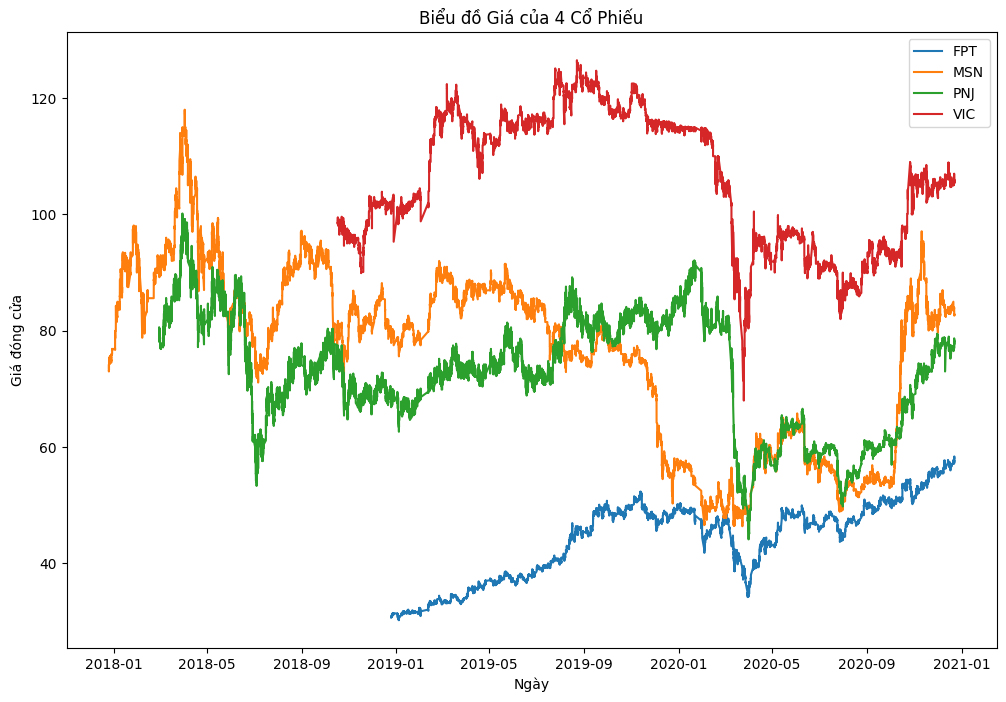

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Danh sách các mã cổ phiếu
tech_list = ['FPT', 'MSN', 'PNJ', 'VIC']

# Thư mục chứa dữ liệu
data_folder = 'data' 

# Vẽ biểu đồ cho mỗi cổ phiếu
plt.figure(figsize=(12, 8))

for stock_symbol in tech_list:
    # Tạo đường dẫn đến dữ liệu
    file_path = os.path.join(data_folder, f'{stock_symbol}.csv')

    
        # tải dữ liệu 
    data = pd.read_csv(file_path, parse_dates=['Date/Time'], index_col='Date/Time')

        # Vẽ biểu đồ giá đóng cửa
    plt.plot(data.index, data['Close'], label=stock_symbol)


plt.title('Biểu đồ Giá của 4 Cổ Phiếu')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()


Vẻ biểu đồ dao động giá

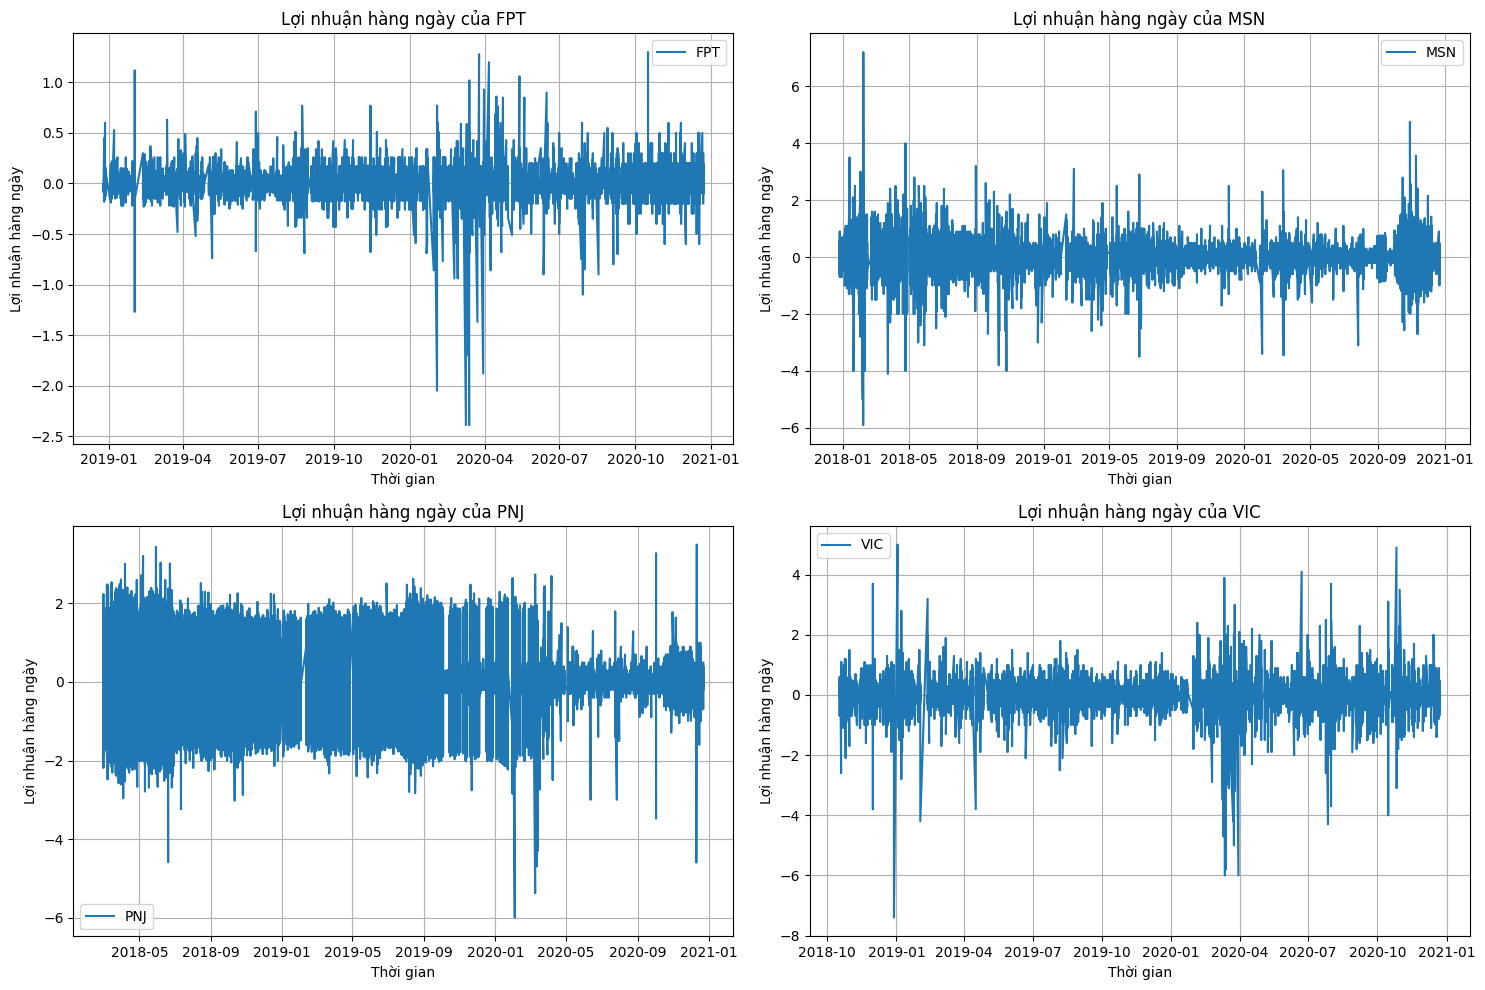

In [21]:

data_folder = 'data'
plt.figure(figsize=(15, 10))
for i, stock_symbol in enumerate(tech_list, 1):
    # Tạo đường dẫn đến file dữ liệu của cổ phiếu
    file_path = os.path.join(data_folder, f'{stock_symbol}.csv')
    
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_path, parse_dates=['Date/Time'])
    
    # Tính toán lợi nhuận hàng ngày
    data['Daily Profit'] = data['Close'].diff()
    
    # Vẽ biểu đồ lợi nhuận hàng ngày cho cổ phiếu thứ i
    plt.subplot(2, 2, i)
    plt.plot(data['Date/Time'], data['Daily Profit'], label=stock_symbol)
    plt.title(f'Lợi nhuận hàng ngày của {stock_symbol}')
    plt.xlabel('Thời gian')
    plt.ylabel('Lợi nhuận hàng ngày')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


vẻ biểu đồ biến động giá bằng công thức Biến động giá cổ phiếu = Giá cổ phiếu N (ngày) sau - Giá cổ phiếu hiện tại

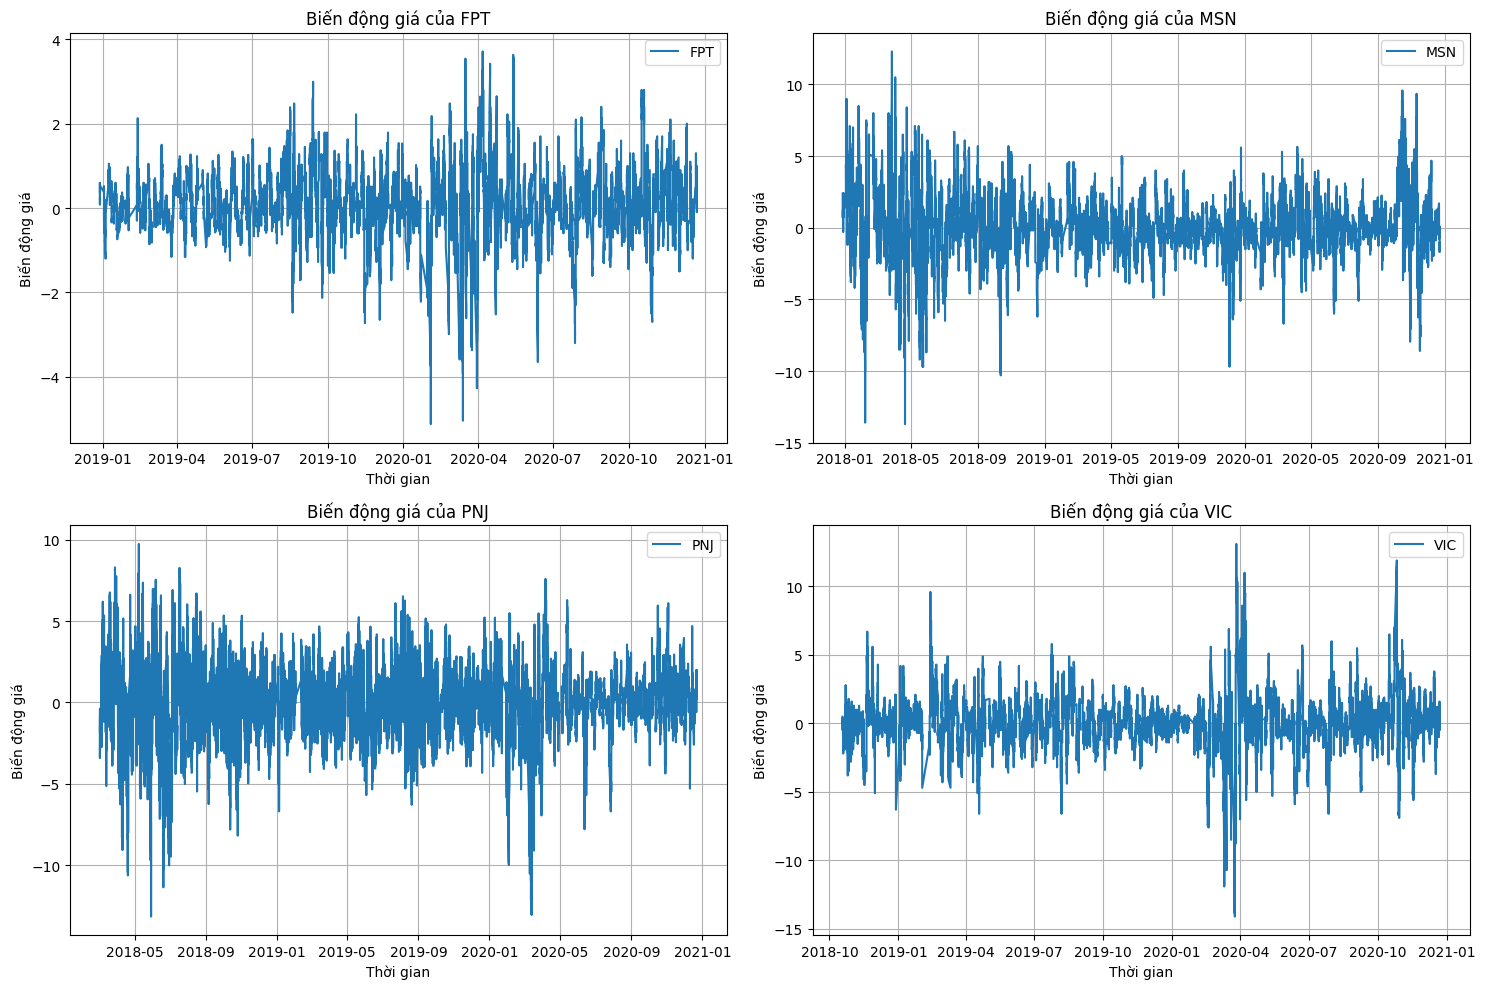

In [9]:
plt.figure(figsize=(15, 10))

# Lặp qua từng mã cổ phiếu trong danh sách
for i, stock_symbol in enumerate(tech_list, 1):
    # Tạo đường dẫn đến file dữ liệu của cổ phiếu
    file_path = os.path.join(data_folder, f'{stock_symbol}.csv')

    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_path, parse_dates=['Date/Time'])

    # Tính toán biến động giá
    data['Price Change'] = data['Close'] - data['Close'].shift(1)

    # Vẽ biểu đồ biến động giá cho cổ phiếu thứ i
    plt.subplot(2, 2, i)
    plt.plot(data['Date/Time'], data['Price Change'], label=stock_symbol)
    plt.title(f'Biến động giá của {stock_symbol}')
    plt.xlabel('Thời gian')
    plt.ylabel('Biến động giá')
    plt.legend()
    plt.grid(True)

# Căn chỉnh layout
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


Học máy dự đoán biến động giá cổ phiếu

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [24]:
# Đọc dữ liệu
fpt = pd.read_csv('data/FPT.csv')
msn = pd.read_csv('data/MSN.csv')
pnj = pd.read_csv('data/PNJ.csv')
vic = pd.read_csv('data/VIC.csv')

# lấy cột Data/Time và Close để làm đặt trưng cho học máy
fpt = fpt[['Date/Time', 'Close']].rename(columns={'Close': 'FPT', 'Date/Time': 'DateTime'})
msn = msn[['Date/Time', 'Close']].rename(columns={'Close': 'MSN', 'Date/Time': 'DateTime'})
pnj = pnj[['Date/Time', 'Close']].rename(columns={'Close': 'PNJ', 'Date/Time': 'DateTime'})
vic = vic[['Date/Time', 'Close']].rename(columns={'Close': 'VIC', 'Date/Time': 'DateTime'})

In [25]:
# gọp dữ liệu lại
data = fpt.merge(msn, on='DateTime').merge(pnj, on='DateTime').merge(vic, on='DateTime')
data = data.set_index('DateTime')

In [26]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [27]:
# Hàm tạo tập dữ liệu cho LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, :])
    return np.array(dataX), np.array(dataY)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [28]:
# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [29]:
# Định hình lại dữ liệu cho LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [30]:
# Xây dựng mô hình LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(X_train.shape[2])) 

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 4)                 104       
                                                                 
Total params: 32,579
Trainable params: 32,579
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Huấn luyện mô hình
model.fit(X_train, y_train, batch_size=1, epochs=1)

41225/41225 [==============================] - 1135s 27ms/step - loss: 3.3394e-04


In [32]:
# Dự đoán trên tập kiểm tra
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

553/553 [==============================] - 14s 25ms/step


In [33]:
# Chuyển đổi giá trị về thang đo ban đầu
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Chuyển đổi y_train và y_test về thang đo ban đầu để so sánh
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

Train Score: 0.14576225958090375 RMSE
Test Score: 0.4566628498870304 RMSE


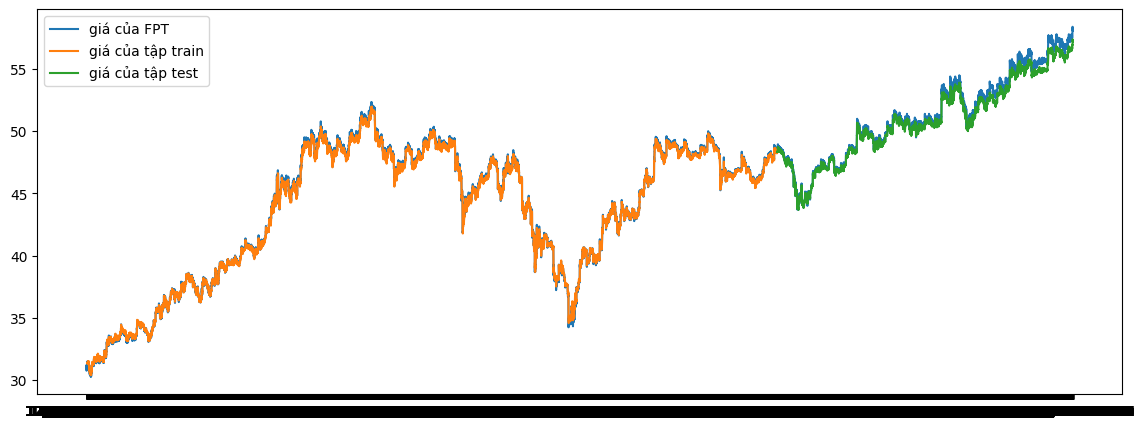

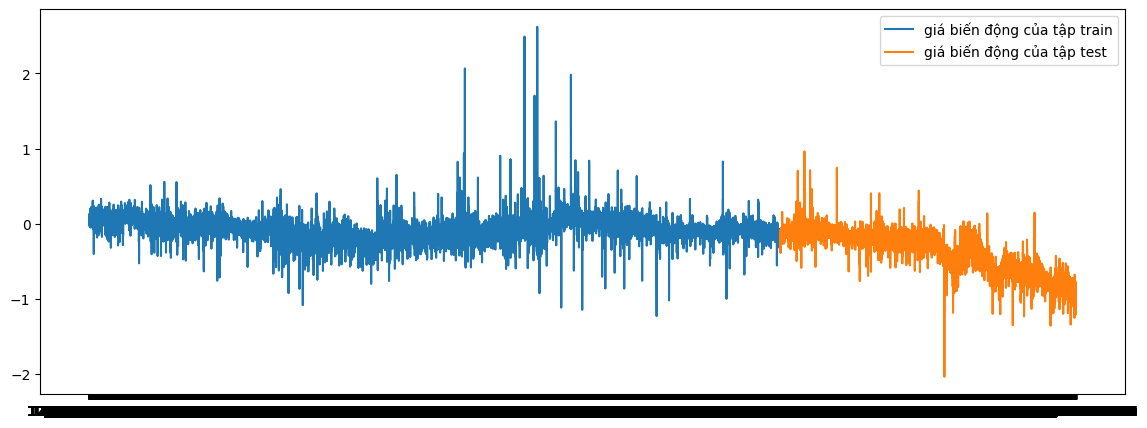

In [34]:
# Đánh giá mô hình
import math
from sklearn.metrics import mean_squared_error

train_score = math.sqrt(mean_squared_error(y_train_inv[:,0], train_predict[:,0]))
print(f'Train Score: {train_score} RMSE')

test_score = math.sqrt(mean_squared_error(y_test_inv[:,0], test_predict[:,0]))
print(f'Test Score: {test_score} RMSE')

# Tính toán biến động giá cổ phiếu = giá dự đoán của mô hình (giá cổ phiếu tương lai) - giá thực tế của cổ phiếu hiện tại
train_stock_change = train_predict - y_train_inv
test_stock_change = test_predict - y_test_inv

# Vẽ đồ thị dự đoán
plt.figure(figsize=(14,5))

# Vẽ dữ liệu của FPT
plt.plot(data.index, scaler.inverse_transform(scaled_data)[:,0], label='giá của FPT')

# Vẽ dữ liệu train
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict
plt.plot(data.index, train_plot[:,0], label='giá của tập train')

# Vẽ dữ liệu test
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step)+1:len(scaled_data)-1, :] = test_predict[:len(test_plot[len(train_predict)+(time_step)+1:len(scaled_data)-1, :]), :]
plt.plot(data.index, test_plot[:,0], label='giá của tập test')

plt.legend()
plt.show()

# Vẽ đồ thị biến động giá cổ phiếu
plt.figure(figsize=(14,5))

# Biến động giá cổ phiếu của tập train
train_change_plot = np.empty_like(scaled_data)
train_change_plot[:, :] = np.nan
train_change_plot[time_step:len(train_predict)+time_step, :] = train_stock_change
plt.plot(data.index, train_change_plot[:,0], label='giá biến động của tập train')

# Biến động giá cổ phiếu của tập test
test_change_plot = np.empty_like(scaled_data)
test_change_plot[:, :] = np.nan
test_change_plot[len(train_predict)+(time_step)+1:len(scaled_data)-1, :] = test_stock_change[:len(test_change_plot[len(train_predict)+(time_step)+1:len(scaled_data)-1, :]), :]
plt.plot(data.index, test_change_plot[:,0], label='giá biến động của tập test')

plt.legend()
plt.show()

Vẻ biểu đồ giá cổ phiếu để có thể kiểm tra xem dữ liệu train và test có chính xác không sau khi thấy dữ liệu train và test dự đoán khá chính xác tuy chỉ có tập test do dữ liệu ít nên độ sai số khá cao là 0.4 nên dữ liệu có tí sai lệch nhưng không đáng kể. Sau khi thấy dữ liệu khá ổn thì mình sử dụng dữ liệu đó để có thể dự đoán biến động giá cổ phiếu.